In [1]:
# general imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns

# from our documents
import OurFunctions as of

# from Scikit Learn library
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import plot_tree 
from sklearn.calibration import CalibratedClassifierCV


# from Imb Learn
from imblearn.over_sampling import SMOTENC, SMOTE

#seed for random processes
seed = 42
np.random.seed(seed)


The aim of this source code is to reproduce the final outcomes of our study. In this way we provide you the preprocessed datasets. If you want to study in details the preprocessing see the file data_preprocessing.ipynb.

In [2]:
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))

In [3]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic, ASD_diagnosis['DX_GROUP'], test_size=0.3, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (213, 8)
Test set size: (92, 8)


In [4]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Initializing SMOTE-NC 
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applying SMOTE-NC in order to generate new syntetic samples
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# CLASSIFICATION

## General pipeline

In [5]:
def general_pipeline(dataset, target, classifier, encoder = True, scaler = True, parameters_grid_search = None, cv = None, feature_selector=False,  parameters_feature_selector = None):

    # Defining metrics to be used as scoring 
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Preprocess to make on the train data may include
    # - normalization of the numerical columns
    # - one hot encoding on the categorical columns
    
    categorical_columns = dataset.select_dtypes(include=['object']).columns

    if not encoder: #only scaler
        transformers = [('num', RobustScaler(), ~dataset.columns.isin(categorical_columns))]
    elif not scaler: #only encoder
        transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    elif not encoder and not scaler:
        transformers = []
    else: # both scaler and encoder
        transformers=[
            ('num', RobustScaler(), ~dataset.columns.isin(categorical_columns)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ]

    preprocessor = ColumnTransformer(transformers=transformers)

    # set parameters per KNN case
    if isinstance(classifier, KNeighborsClassifier):
        parameter_type = 'classifier__n_neighbors'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # n_neighbors values to be explored 
        else:
            parameters = {parameter_type: [3, 5, 7, 9, 11]} 

        feature_selector_type = SelectKBest(score_func=f_classif)
        selector_parameter = 'feature_selection__k'
        
    # set parameters per RF case
    if isinstance(classifier, RandomForestClassifier):
        parameter_type = 'classifier__n_estimators'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [10, 50, 200, 500, 1000]} 

        feature_selector_type = RFE(estimator=classifier)
        selector_parameter = 'feature_selection__n_features_to_select'

    # set parameters per LinearSVC case
    if isinstance(classifier, CalibratedClassifierCV):
        parameter_type = 'classifier__estimator__C'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [0.001, 0.01, 0.1, 1, 10, 100]}  

        feature_selector_type = RFE(estimator=LinearSVC(dual=False, random_state=42))
        selector_parameter = 'feature_selection__n_features_to_select'

    
    if feature_selector: # in case feature selection is required
        
        sample_transformed = preprocessor.fit_transform(dataset)
        n_total_features = sample_transformed.shape[1]
        print("Total quantity of features after one hot encoding :" + str(n_total_features))
        
        # Pipeline with feature selector
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector_type),
        ('classifier', classifier)  
        ])
        if parameters_feature_selector:
            parameters.update({selector_parameter: parameters_feature_selector})
        else: 
            parameters.update({selector_parameter: list(range(1, n_total_features+1))})
            
    else:
        # Pipeline without feature selector
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier),
            ])

    # allows to change k of cross validation from the outside
    if cv:
        k_folds = cv
    else:
        k_folds = 5

    # Creating GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv= KFold(n_splits=k_folds, shuffle = True, random_state = 42), scoring=scoring, refit='accuracy')

    # Executing 
    grid_search.fit(dataset, target)

    # Extraction of results

    means_accuracy = grid_search.cv_results_['mean_test_accuracy']
    stds_accuracy = grid_search.cv_results_['std_test_accuracy']
    means_precision = grid_search.cv_results_['mean_test_precision']
    means_recall = grid_search.cv_results_['mean_test_recall']
    means_f1_score = grid_search.cv_results_['mean_test_f1_score']
    params = grid_search.cv_results_['params']

    best_model = grid_search.best_estimator_
    best_parameter = [grid_search.best_params_[parameter_type]]
    best_accuracy = grid_search.best_score_
    best_f1_score = grid_search.cv_results_['mean_test_f1_score'][grid_search.best_index_]
    best_scores = [best_accuracy, best_f1_score]

    feature_names = []
    for feature in best_model.named_steps['preprocessor'].get_feature_names_out():
        feature_names.append(feature)
    # Visualization of results

    if not parameters_grid_search: #the parameter is not choose from the outside
        print("Cross-validation results for each combination of hyperparameters:")
        for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
            print(f"Parameters: {params}, Accuracy: {mean_acc:.3f} (±{std_acc:.3f}), Precision: {mean_prec:.3f}, Recall: {mean_rec:.3f}, F1-score: {mean_f1:.3f}")

        print("\nBest parameter founded:")
        print(best_parameter)
        print("\nThe scores achieved are:")

    print("Accuracy:", best_accuracy)
    print("F1-score:", best_f1_score)

    if feature_selector:
        # Get the support mask and selected feature names from the preprocessed data
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        selected_mask = best_model.named_steps['feature_selection'].get_support()
        selected_features = []
        for feature in feature_names[selected_mask]:
            selected_features.append(feature)

        print("\nSelected features are:")
        print(f"Number of selected features: {len(selected_features)}")
        print("Selected features:", selected_features)

        non_selected_mask = ~selected_mask
        non_selected_features = feature_names[non_selected_mask]

        print("\nNon selected features are:")
        print(f"Number of non selected features: {len(non_selected_features)}")
        print("Selected features:", non_selected_features)

        best_parameter.append(grid_search.best_params_[selector_parameter])

        return best_model, best_parameter, best_scores, selected_features
        
    return best_model, best_parameter, best_scores, feature_names
    

## Random Forest: Best Classification model

- Random Forest Classifier
- 50 trees
- No outlier remotion
- No feature selection

In [6]:
classifier = RandomForestClassifier(random_state=42)
rf_model, rf_parameter, rf_scores, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [50])

Accuracy: 0.9845673076923077
F1-score: 0.9847978436657682


In [7]:
# Evaluation Model on Test Data 
y_pred = rf_model.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)



Model Evaluation on Test Data:
Accuracy: 0.967
Precision: 1.000
Recall: 0.955
F1-score: 0.977


## K-Nearest Neighbours: Second Best Classification model

- K-Nearest Neighbors
- Best k = 3
- No outlier remotion
- 2 features selected in Feature selection 

In [8]:
classifier = KNeighborsClassifier()

knn_model, knn_parameter, knn_scores, knn_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [3], feature_selector=True)

Total quantity of features after one hot encoding :11
Accuracy: 0.9660576923076925
F1-score: 0.965389466091007

Selected features are:
Number of selected features: 2
Selected features: ['num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL']

Non selected features are:
Number of non selected features: 9
Selected features: ['num__AGE_AT_SCAN' 'num__SEX' 'num__FIQ' 'num__VIQ' 'num__PIQ'
 'cat__PIQ_TEST_TYPE_DAS' 'cat__PIQ_TEST_TYPE_WAIS'
 'cat__PIQ_TEST_TYPE_WASI' 'cat__PIQ_TEST_TYPE_WISC']


In [9]:
# Evaluation Model on Test Data 
y_pred = knn_model.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)


Model Evaluation on Test Data:
Accuracy: 0.935
Precision: 1.000
Recall: 0.910
F1-score: 0.953


## Linear Support Vector Classifier: Third Best Classification model

- Linear Support Vector Classifier
- Default parameter
- No outlier remotion
- No feature selection

In [10]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False, random_state=42))
svc_model, svc_parameter, svc_scores, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search= [1])

Accuracy: 0.9568269230769232
F1-score: 0.9553350675089807


# Comparison of the results

K-Nearest Neighbors Classifier AUC-ROC: 0.9740298507462687
Random Forest Classifier AUC-ROC: 0.9859701492537313
Support vector Classifier AUC-ROC: 0.9719402985074628


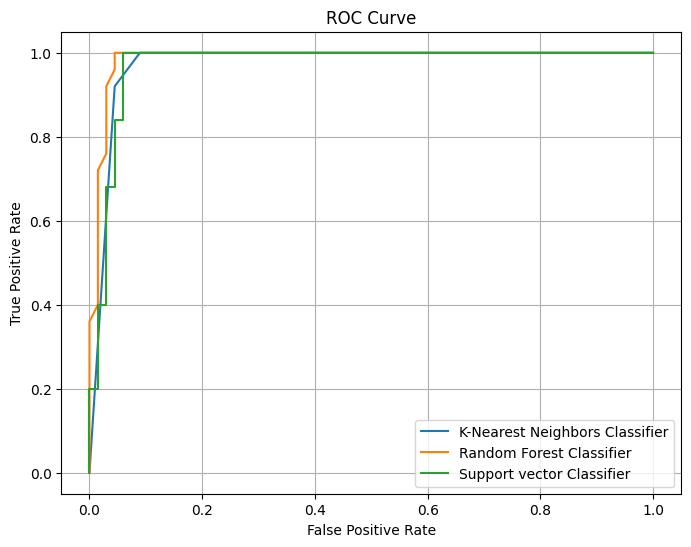

In [11]:
knn_auc_roc = of.evaluate_roc_auc(knn_model, X_test, y_test)
rf_auc_roc = of.evaluate_roc_auc(rf_model, X_test, y_test)
svc_auc_roc = of.evaluate_roc_auc(svc_model, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)
print("Support vector Classifier AUC-ROC:", svc_auc_roc)

# We need to make the diagnostic binary (instead of 1 and 2)
y_test_binary = (y_test == 2).astype(int)

plt.figure(figsize=(8, 6))
of.plot_roc_curve(knn_model, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
of.plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
of.plot_roc_curve(svc_model, X_test, y_test_binary, 'Support vector Classifier')
plt.show()